In [1]:
!pip -q install -U transformers accelerate scikit-learn

import torch, os, random, numpy as np
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 89.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 89.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/21

# Install + Imports

# Configuration

In [2]:


import json, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# -------- Paths --------
DATA_DIR = Path("/kaggle/input/dataaaaaa")
WORK_DIR = Path("/kaggle/working"); WORK_DIR.mkdir(exist_ok=True)

# -------- Models --------
TEACHER_MODEL_ID = "xlm-roberta-base"                 # teacher backbone
STUDENT_MODEL_ID = "distilbert-base-uncased"  # mDistilBERT student

# -------- Training params --------
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS_TEACHER = 3
EPOCHS_STUDENT = 4
LR_TEACHER = 2e-5
LR_STUDENT = 3e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
PATIENCE = 2

# -------- KD hyperparams --------
KD_T = 3.0          # temperature
KD_ALPHA = 0.5      # weight on soft vs hard loss
GAMMA_HIDDEN = 1.0  # hidden-state MSE weight
GAMMA_ATT   = 1.0   # attention-map MSE weight

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def compute_metrics(preds, labels):
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
    }


Device: cuda


# Split & Convert to Dataset

In [3]:
def read_lines(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

pos = read_lines(DATA_DIR / "all_positive_8500.txt")
neg = read_lines(DATA_DIR / "all_negative_3307.txt")

df = pd.concat([
    pd.DataFrame({"text": pos, "label": 1}),
    pd.DataFrame({"text": neg, "label": 0}),
], ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

train_df, tmp_df = train_test_split(df, test_size=0.2, stratify=df.label, random_state=SEED)
val_df, test_df  = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df.label, random_state=SEED)
print(f"Split → Train={len(train_df)}  Val={len(val_df)}  Test={len(test_df)}")


Split → Train=9445  Val=1181  Test=1181


# Fine-Tune Teacher (XLM-R) + Save

In [4]:
teacher_tok = AutoTokenizer.from_pretrained(TEACHER_MODEL_ID)

class SimpleDataset(Dataset):
    def __init__(self, df, tok, max_len):
        self.texts = df.text.tolist()
        self.labels = df.label.tolist()
        self.tk = tok; self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = self.tk(self.texts[i], truncation=True, max_length=self.max_len, return_tensors="pt")
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

def pad_collate(batch, pad_id):
    keys = batch[0].keys(); out = {}
    for k in keys:
        if k=="labels": out[k]=torch.stack([b[k] for b in batch])
        else:
            pad_val = 0 if k=="attention_mask" else pad_id
            out[k]=nn.utils.rnn.pad_sequence([b[k] for b in batch], batch_first=True, padding_value=pad_val)
    return out

train_loader = DataLoader(SimpleDataset(train_df, teacher_tok, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id))
val_loader   = DataLoader(SimpleDataset(val_df, teacher_tok, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id))
test_loader  = DataLoader(SimpleDataset(test_df, teacher_tok, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda b: pad_collate(b, teacher_tok.pad_token_id))

teacher = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL_ID, num_labels=2).to(DEVICE)

opt_t = AdamW(teacher.parameters(), lr=LR_TEACHER, weight_decay=WEIGHT_DECAY)
steps_t = len(train_loader)*EPOCHS_TEACHER
sched_t = get_linear_schedule_with_warmup(opt_t, int(WARMUP_RATIO*steps_t), steps_t)

def eval_cls(model, loader):
    model.eval(); preds, gold = [], []
    with torch.no_grad():
        for b in loader:
            b = {k:v.to(DEVICE) for k,v in b.items()}
            out = model(**b)
            preds += out.logits.argmax(-1).detach().cpu().tolist()
            gold  += b["labels"].detach().cpu().tolist()
    return compute_metrics(np.array(preds), np.array(gold))

best_f1, wait = -1, 0
for ep in range(1, EPOCHS_TEACHER+1):
    teacher.train(); run_loss = 0.0
    for b in tqdm(train_loader, desc=f"[Teacher XLM-R] Epoch {ep}", leave=False):
        b = {k:v.to(DEVICE) for k,v in b.items()}
        out = teacher(**b)
        loss = out.loss
        loss.backward()
        nn.utils.clip_grad_norm_(teacher.parameters(), 1.0)
        opt_t.step(); sched_t.step(); opt_t.zero_grad()
        run_loss += loss.item()

    val = eval_cls(teacher, val_loader)
    print(f"Epoch {ep} | loss={run_loss/len(train_loader):.4f} | Val F1m={val['f1_macro']:.4f} Acc={val['accuracy']:.4f}")
    if val["f1_macro"] > best_f1:
        best_f1, wait = val["f1_macro"], 0
        (WORK_DIR/"finetuned_xlmr").mkdir(exist_ok=True)
        teacher.save_pretrained(WORK_DIR/"finetuned_xlmr")
        teacher_tok.save_pretrained(WORK_DIR/"finetuned_xlmr")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stop teacher."); break

teacher = AutoModelForSequenceClassification.from_pretrained(WORK_DIR/"finetuned_xlmr").to(DEVICE)
teacher_tok = AutoTokenizer.from_pretrained(WORK_DIR/"finetuned_xlmr")
print("[Teacher XLM-R][Test]:", eval_cls(teacher, test_loader))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2025-11-01 22:07:08.022583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762034828.442874      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762034828.553692      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Teacher XLM-R] Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 1 | loss=0.3746 | Val F1m=0.9411 Acc=0.9517


[Teacher XLM-R] Epoch 2:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 2 | loss=0.1633 | Val F1m=0.9408 Acc=0.9534


[Teacher XLM-R] Epoch 3:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 3 | loss=0.1049 | Val F1m=0.9507 Acc=0.9602
[Teacher XLM-R][Test]: {'accuracy': 0.951735817104149, 'f1_macro': 0.9403485141846957, 'f1_weighted': 0.9518020223536807}


# Prepare for KD (Shared Tokenizer = Teacher’s)

In [5]:
# ==============================================================
# 📦 Prepare KD (Shared Tokenizer = Teacher’s) + KD Dataloaders
# ==============================================================

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# --------------------------------------------------------------
# ✅ Use shared tokenizer (teacher = XLM-R)
# --------------------------------------------------------------
shared_tok = teacher_tok
print(f"✅ Shared tokenizer loaded from teacher (XLM-R)")
print(f"📘 Vocab size: {len(shared_tok)}")

# --------------------------------------------------------------
# 🧾 Dataset class for KD (rebuild using shared tokenizer)
# --------------------------------------------------------------
class KDDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df.text.tolist()
        self.labels = df.label.tolist()
        self.tk = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        enc = self.tk(
            self.texts[i],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

# --------------------------------------------------------------
# 🔧 Collate function for dynamic padding
# --------------------------------------------------------------
def pad_collate(batch, pad_id):
    keys = batch[0].keys()
    out = {}
    for k in keys:
        if k == "labels":
            out[k] = torch.stack([b[k] for b in batch])
        else:
            pad_val = 0 if k == "attention_mask" else pad_id
            out[k] = nn.utils.rnn.pad_sequence(
                [b[k] for b in batch],
                batch_first=True,
                padding_value=pad_val
            )
    return out

# --------------------------------------------------------------
# 🧠 Build KD dataloaders using shared tokenizer
# --------------------------------------------------------------
train_loader = DataLoader(
    KDDataset(train_df, shared_tok, MAX_LEN),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda b: pad_collate(b, shared_tok.pad_token_id)
)

val_loader = DataLoader(
    KDDataset(val_df, shared_tok, MAX_LEN),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: pad_collate(b, shared_tok.pad_token_id)
)

test_loader = DataLoader(
    KDDataset(test_df, shared_tok, MAX_LEN),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: pad_collate(b, shared_tok.pad_token_id)
)

# --------------------------------------------------------------
# ✅ Sanity check
# --------------------------------------------------------------
batch = next(iter(train_loader))
print("🧩 KD Dataloaders ready!")
print(f"Train batches: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")
print("Batch shapes → input_ids:", batch["input_ids"].shape, "| labels:", batch["labels"].shape)


✅ Shared tokenizer loaded from teacher (XLM-R)
📘 Vocab size: 250002
🧩 KD Dataloaders ready!
Train batches: 591 | Val: 74 | Test: 74
Batch shapes → input_ids: torch.Size([16, 128]) | labels: torch.Size([16])


# Student (DistilBERT) + KD Loss (logits + hidden + attention)

In [6]:
import inspect
import torch.nn.functional as F

class StudentClassifier(nn.Module):
    def __init__(self, base_model_id, num_labels=2, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_id)
        # align to shared tokenizer
        self.encoder.resize_token_embeddings(len(shared_tok))
        H = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(H, num_labels)
        if hasattr(self.encoder, "config"):
            try: self.encoder.config.attn_implementation = "eager"
            except: pass

    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        # Filter unsupported/duplicate kwargs (DistilBERT has no token_type_ids)
        sig = inspect.signature(self.encoder.forward)
        valid = {k:v for k,v in kwargs.items() if k in sig.parameters}
        for k in ["output_hidden_states", "output_attentions", "return_dict"]:
            valid.pop(k, None)

        out = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True,
            **valid
        )
        cls = out.last_hidden_state[:, 0, :]
        logits = self.classifier(self.dropout(cls))
        return {"logits": logits, "hidden_states": out.hidden_states, "attentions": out.attentions}

student = StudentClassifier(STUDENT_MODEL_ID, num_labels=2).to(DEVICE)

class KDLossFull(nn.Module):
    def __init__(self, T=3.0, alpha=0.5, gamma_h=1.0, gamma_a=1.0):
        super().__init__()
        self.T, self.alpha, self.gamma_h, self.gamma_a = T, alpha, gamma_h, gamma_a
        self.ce = nn.CrossEntropyLoss()
        self.kld = nn.KLDivLoss(reduction="batchmean")
        self.mse = nn.MSELoss()

    @staticmethod
    def map_layers(n_s, n_t, att=False):
        if att:  # attentions indexed 0..L-1
            s_idx = list(range(n_s))
            t_pos = torch.linspace(0, n_t-1, steps=len(s_idx)).round().long().tolist()
        else:    # hidden_states: 1..L (ignore embeddings at 0)
            s_idx = list(range(1, n_s+1))
            t_pos = torch.linspace(1, n_t,   steps=len(s_idx)).round().long().tolist()
        return list(zip(s_idx, t_pos))

    def logits_loss(self, s_logits, t_logits, labels):
        hard = self.ce(s_logits, labels)
        log_p_s = F.log_softmax(s_logits / self.T, dim=-1)
        p_t     = F.softmax(t_logits / self.T, dim=-1)
        soft = self.kld(log_p_s, p_t) * (self.T**2)
        return (1-self.alpha)*hard + self.alpha*soft, hard.item(), soft.item()

    def hidden_loss(self, hs_s, hs_t):
        n_s, n_t = len(hs_s)-1, len(hs_t)-1
        pairs = self.map_layers(n_s, n_t, att=False)
        losses = []
        for s_i, t_i in pairs:
            s, t = hs_s[s_i], hs_t[t_i]           # (B, L, H)
            L = min(s.size(1), t.size(1))
            s, t = s[:, :L, :], t[:, :L, :]
            Hs, Ht = s.size(-1), t.size(-1)
            if Hs != Ht:  # pad or trim s to Ht
                if Hs > Ht: s = s[..., :Ht]
                else:
                    pad = torch.zeros(s.size(0), s.size(1), Ht-Hs, device=s.device, dtype=s.dtype)
                    s = torch.cat([s, pad], dim=-1)
            losses.append(self.mse(s, t))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=hs_s[0].device)

    def att_loss(self, at_s, at_t):
        n_s, n_t = len(at_s), len(at_t)
        pairs = self.map_layers(n_s, n_t, att=True)
        losses = []
        for s_i, t_i in pairs:
            s, t = at_s[s_i], at_t[t_i]           # (B, H, L, L)
            s = s.mean(dim=1); t = t.mean(dim=1)  # average heads
            s = F.softmax(s, dim=-1); t = F.softmax(t, dim=-1)
            L = min(s.size(-1), t.size(-1))
            losses.append(self.mse(s[:, :L, :L], t[:, :L, :L]))
        return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=at_s[0].device)

    def forward(self, s_pack, t_pack, labels):
        total, hard, soft = self.logits_loss(s_pack["logits"], t_pack["logits"], labels)
        h = self.hidden_loss(s_pack["hidden_states"], t_pack["hidden_states"]) if self.gamma_h>0 else 0.0
        a = self.att_loss(  s_pack["attentions"],    t_pack["attentions"])    if self.gamma_a>0 else 0.0
        total = total + self.gamma_h*h + self.gamma_a*a
        return total, {"hard":hard, "soft":soft, "hidden":float(h), "att":float(a)}

criterion = KDLossFull(T=KD_T, alpha=KD_ALPHA, gamma_h=GAMMA_HIDDEN, gamma_a=GAMMA_ATT)
print("✅ Student + KD loss ready.")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


✅ Student + KD loss ready.


# Evaluation function

In [7]:
# freeze teacher
teacher.eval()
for p in teacher.parameters(): p.requires_grad = False

opt_s   = AdamW(student.parameters(), lr=LR_STUDENT, weight_decay=WEIGHT_DECAY)
steps_s = len(train_loader)*EPOCHS_STUDENT
sched_s = get_linear_schedule_with_warmup(opt_s, int(WARMUP_RATIO*steps_s), steps_s)

def eval_student(loader):
    student.eval(); preds, gold = [], []
    with torch.no_grad():
        for b in loader:
            b = {k:v.to(DEVICE) for k,v in b.items()}
            out = student(input_ids=b["input_ids"], attention_mask=b["attention_mask"])
            preds += out["logits"].argmax(-1).detach().cpu().tolist()
            gold  += b["labels"].detach().cpu().tolist()
    return compute_metrics(np.array(preds), np.array(gold))

best_f1, wait = -1, 0
for ep in range(1, EPOCHS_STUDENT+1):
    student.train(); run_loss = 0.0
    for b in tqdm(train_loader, desc=f"[KD XLM-R → mDistilBERT] Epoch {ep}", leave=False):
        b = {k:v.to(DEVICE) for k,v in b.items()}
        labels = b["labels"]

        # student pass
        s_out = student(input_ids=b["input_ids"], attention_mask=b["attention_mask"],
                        output_hidden_states=True, output_attentions=True)

        # teacher pass (no grad)
        with torch.no_grad():
            t_raw = teacher(input_ids=b["input_ids"], attention_mask=b["attention_mask"],
                            output_hidden_states=True, output_attentions=True, return_dict=True)
            t_out = {"logits": t_raw.logits, "hidden_states": t_raw.hidden_states, "attentions": t_raw.attentions}

        loss, parts = criterion(s_out, t_out, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(student.parameters(), 1.0)
        opt_s.step(); sched_s.step(); opt_s.zero_grad()
        run_loss += loss.item()

    val = eval_student(val_loader)
    print(f"Epoch {ep} | loss={run_loss/len(train_loader):.4f} | Val F1m={val['f1_macro']:.4f} Acc={val['accuracy']:.4f}")

    if val["f1_macro"] > best_f1:
        best_f1, wait = val["f1_macro"], 0
        torch.save(student.state_dict(), WORK_DIR/"student_mdistilbert_best.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stop student."); break

student.load_state_dict(torch.load(WORK_DIR/"student_mdistilbert_best.pt", map_location=DEVICE))
student.eval()
print("✅ KD finished.")


[KD XLM-R → mDistilBERT] Epoch 1:   0%|          | 0/591 [00:00<?, ?it/s]

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1 | loss=1.7569 | Val F1m=0.8292 Acc=0.8806


[KD XLM-R → mDistilBERT] Epoch 2:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 2 | loss=0.8112 | Val F1m=0.9080 Acc=0.9297


[KD XLM-R → mDistilBERT] Epoch 3:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 3 | loss=0.4958 | Val F1m=0.9356 Acc=0.9483


[KD XLM-R → mDistilBERT] Epoch 4:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 4 | loss=0.3849 | Val F1m=0.9311 Acc=0.9450
✅ KD finished.


# Teacher↔Student Logit Alignment (val set)

In [8]:
from scipy.stats import pearsonr
from scipy.special import softmax
import numpy as np
import torch.nn.functional as F

def evaluate_model(model, loader):
    model.eval(); preds, gold, probs = [], [], []
    with torch.no_grad():
        for b in loader:
            b = {k:v.to(DEVICE) for k,v in b.items()}
            out = model(**b) if not isinstance(model, StudentClassifier) else model(input_ids=b["input_ids"], attention_mask=b["attention_mask"])
            logits = out["logits"] if isinstance(out, dict) else out.logits
            p = logits.softmax(-1)
            preds += p.argmax(-1).cpu().tolist()
            gold  += b["labels"].cpu().tolist()
            probs += p[:,1].cpu().tolist()
    return compute_metrics(np.array(preds), np.array(gold)), np.array(probs), np.array(preds), np.array(gold)

print("Evaluating teacher...")
teacher_metrics, teacher_probs, teacher_preds, gold = evaluate_model(teacher, test_loader)
print("Evaluating student...")
student_metrics, student_probs, student_preds, _ = evaluate_model(student, test_loader)

print("\n===== 📈 Test Metrics =====")
print(f"🧠 Teacher (XLM-R):           Acc={teacher_metrics['accuracy']:.4f} | F1_macro={teacher_metrics['f1_macro']:.4f} | F1_weighted={teacher_metrics['f1_weighted']:.4f}")
print(f"🎓 Student (mDistilBERT):     Acc={student_metrics['accuracy']:.4f} | F1_macro={student_metrics['f1_macro']:.4f} | F1_weighted={student_metrics['f1_weighted']:.4f}")

@torch.no_grad()
def evaluate_alignment(teacher_model, student_model, loader):
    teacher_model.eval(); student_model.eval()
    cos_sims, prob_corrs, agreements = [], [], []
    for b in loader:
        b = {k:v.to(DEVICE) for k,v in b.items()}
        t_out = teacher_model(**b)
        s_out = student_model(input_ids=b["input_ids"], attention_mask=b["attention_mask"])
        t_logits = t_out.logits
        s_logits = s_out["logits"]

        cos = F.cosine_similarity(t_logits, s_logits, dim=-1).mean().item()
        t_probs = t_logits.softmax(-1).cpu().numpy()
        s_probs = s_logits.softmax(-1).cpu().numpy()
        corr = pearsonr(t_probs[:,1], s_probs[:,1])[0]
        agree = (t_logits.argmax(-1) == s_logits.argmax(-1)).float().mean().item()

        cos_sims.append(cos); prob_corrs.append(corr); agreements.append(agree)
    return {"logit_cosine": float(np.mean(cos_sims)),
            "prob_corr": float(np.mean(prob_corrs)),
            "pred_alignment": float(np.mean(agreements))}

alignment = evaluate_alignment(teacher, student, test_loader)

print("\n===== 🔗 Alignment Metrics =====")
print(f"🔹 Logit Cosine Similarity : {alignment['logit_cosine']:.4f}")
print(f"🔹 Probability Correlation : {alignment['prob_corr']:.4f}")
print(f"🔹 Prediction Agreement    : {alignment['pred_alignment']:.4f}")

# save metrics safely
def make_json_safe(obj):
    if isinstance(obj, dict): return {k: make_json_safe(v) for k,v in obj.items()}
    if isinstance(obj, list): return [make_json_safe(v) for v in obj]
    if hasattr(obj, "item"):  return obj.item()
    return obj

results = {"teacher_test": teacher_metrics, "student_test": student_metrics, "alignment": alignment}
with open(WORK_DIR/"metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(make_json_safe(results), f, indent=2, ensure_ascii=False)
print(f"\n✅ Saved metrics → {WORK_DIR/'metrics_summary.json'}")


Evaluating teacher...
Evaluating student...

===== 📈 Test Metrics =====
🧠 Teacher (XLM-R):           Acc=0.9517 | F1_macro=0.9403 | F1_weighted=0.9518
🎓 Student (mDistilBERT):     Acc=0.9365 | F1_macro=0.9208 | F1_weighted=0.9363

===== 🔗 Alignment Metrics =====
🔹 Logit Cosine Similarity : 0.9041
🔹 Probability Correlation : 0.8916
🔹 Prediction Agreement    : 0.9544

✅ Saved metrics → /kaggle/working/metrics_summary.json


In [9]:
# ==============================================================
# 💬 Manual Inference: Compare Teacher vs Student
# ==============================================================

from scipy.special import softmax

label_names = {0: "NEGATIVE", 1: "POSITIVE"}

def test_one(text_bn: str):
    enc = shared_tok(text_bn, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        t_out = teacher(**enc)
        s_out = student(**enc)

    t_prob = softmax(t_out.logits.cpu().numpy(), axis=-1)[0]
    s_prob = softmax(s_out["logits"].cpu().numpy(), axis=-1)[0]
    t_pred = int(t_prob.argmax()); s_pred = int(s_prob.argmax())

    print("📝", text_bn)
    print(f"🧠 Teacher:  {label_names[t_pred]}  (NEG={t_prob[0]:.4f}, POS={t_prob[1]:.4f})")
    print(f"🎓 Student:  {label_names[s_pred]}  (NEG={s_prob[0]:.4f}, POS={s_prob[1]:.4f})")
    print("🤝 Alignment:", "✅ MATCH" if t_pred==s_pred else "⚠️ DIFFERENT"); print()

for tx in ["আমি আজ খুব খুশি।", "এই সিনেমাটা একদম বাজে।", "ওদের পারফরম্যান্স দারুণ ছিল।", "এটা ভয়ংকর অভিজ্ঞতা।"]:
    test_one(tx)



📝 আমি আজ খুব খুশি।
🧠 Teacher:  POSITIVE  (NEG=0.0005, POS=0.9995)
🎓 Student:  POSITIVE  (NEG=0.0004, POS=0.9996)
🤝 Alignment: ✅ MATCH

📝 এই সিনেমাটা একদম বাজে।
🧠 Teacher:  NEGATIVE  (NEG=0.9980, POS=0.0020)
🎓 Student:  NEGATIVE  (NEG=0.9981, POS=0.0019)
🤝 Alignment: ✅ MATCH

📝 ওদের পারফরম্যান্স দারুণ ছিল।
🧠 Teacher:  POSITIVE  (NEG=0.0006, POS=0.9994)
🎓 Student:  POSITIVE  (NEG=0.0004, POS=0.9996)
🤝 Alignment: ✅ MATCH

📝 এটা ভয়ংকর অভিজ্ঞতা।
🧠 Teacher:  POSITIVE  (NEG=0.0461, POS=0.9539)
🎓 Student:  NEGATIVE  (NEG=0.9942, POS=0.0058)
🤝 Alignment: ⚠️ DIFFERENT



# t-SNE Visualization Cell

Extracting embeddings …
Running t-SNE …


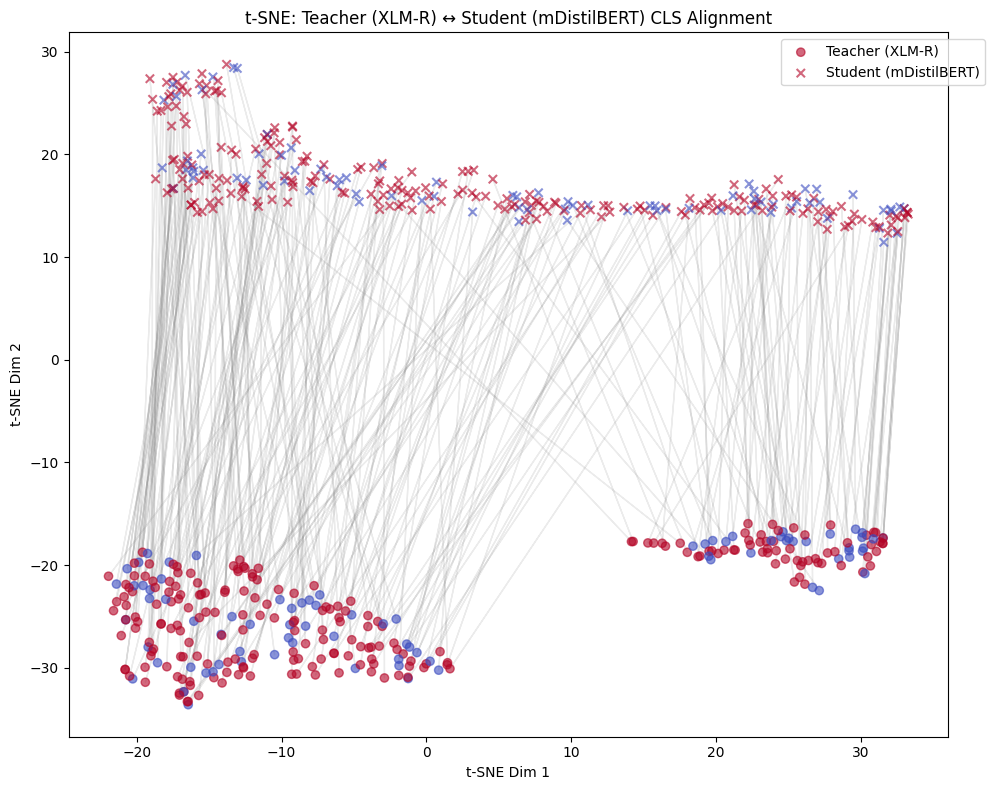

🧩 Mean teacher–student embedding cosine similarity: 0.6142


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import random, numpy as np, torch

teacher.eval(); student.eval()
num_samples = 300
texts = random.sample(test_df.text.tolist(), k=min(num_samples, len(test_df)))
labels = np.array([test_df.label.tolist()[i] for i in range(len(texts))])

def extract_cls_embeddings(model, tokenizer, texts, batch_size=16, max_len=MAX_LEN):
    all_cls = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True, return_dict=True)
            hs = out["hidden_states"] if isinstance(out, dict) else out.hidden_states
            cls_vec = hs[-1][:, 0, :].detach().cpu().numpy()
        all_cls.append(cls_vec)
    return np.concatenate(all_cls, axis=0)

print("Extracting embeddings …")
teacher_embs = extract_cls_embeddings(teacher, shared_tok, texts)
student_embs = extract_cls_embeddings(student, shared_tok, texts)

print("Running t-SNE …")
all_embs = np.concatenate([teacher_embs, student_embs], axis=0)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto", max_iter=1500)
all_2d = tsne.fit_transform(all_embs)
n = len(texts)
teacher_2d, student_2d = all_2d[:n], all_2d[n:]

plt.figure(figsize=(10,8))
for i in range(n):
    plt.arrow(teacher_2d[i,0], teacher_2d[i,1],
              student_2d[i,0]-teacher_2d[i,0], student_2d[i,1]-teacher_2d[i,1],
              color="gray", alpha=0.15, head_width=0.0, length_includes_head=True)
plt.scatter(teacher_2d[:,0], teacher_2d[:,1], c=labels, cmap="coolwarm", marker="o", alpha=0.6, label="Teacher (XLM-R)")
plt.scatter(student_2d[:,0], student_2d[:,1], c=labels, cmap="coolwarm", marker="x", alpha=0.6, label="Student (mDistilBERT)")
plt.title("t-SNE: Teacher (XLM-R) ↔ Student (mDistilBERT) CLS Alignment")
plt.xlabel("t-SNE Dim 1"); plt.ylabel("t-SNE Dim 2"); plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout(); plt.show()

mean_cos = cosine_similarity(teacher_embs, student_embs).diagonal().mean()
print(f"🧩 Mean teacher–student embedding cosine similarity: {mean_cos:.4f}")
